### Load hidden states

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy
import pickle
import os
import numpy as np

In [3]:
import time
import numpy as np
import pandas as pd
import matplotlib
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.decomposition import PCA

%matplotlib inline

In [4]:
import scipy.stats as ss
from collections import defaultdict
from sklearn.cluster import KMeans

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set()

In [6]:
np.random.seed(21)

In [7]:
sns.set(font_scale=2)
sns.set_style("white")
sns.set_palette("tab10")

In [8]:
import matplotlib.pyplot as plt
plt.style.use(['science', 'no-latex', 'grid'])

In [9]:
os.chdir("..")

In [10]:
base_name = "concat60"
base_name_2nd = "concat101"

In [11]:
N=3000

In [12]:
with open(f"experiments/en_et_{base_name}/internals/data_encoded{N}.pkl", 'rb') as f:
    hiddens_base = pickle.load(f) 

In [13]:
with open(f"experiments/en_et_{base_name_2nd}/internals/data_encoded{N}.pkl", 'rb') as f:
    hiddens_base_2nd = pickle.load(f) 

In [14]:
with open(f"experiments/en_et_Europarl_ft/internals/data_encoded{N}.pkl", 'rb') as f:
    hiddens_europarl = pickle.load(f)

with open(f"experiments/en_et_OpenSubtitles_ft/internals/data_encoded{N}.pkl", 'rb') as f:
    hiddens_opensubs = pickle.load(f) 
    
with open(f"experiments/en_et_JRC-Acquis_ft/internals/data_encoded{N}.pkl", 'rb') as f:
    hiddens_jrc = pickle.load(f)

with open(f"experiments/en_et_EMEA_ft/internals/data_encoded{N}.pkl", 'rb') as f:
    hiddens_emea = pickle.load(f) 

In [15]:
def flatten_words_stream(v):
    # transpose
    v = list(map(list, zip(*v)))
    
    # squeze
    for i, layer in enumerate(v):
        for j, sentence in enumerate(layer):
            new_sentence = sentence.squeeze(0)
            v[i][j] = new_sentence 
    
    # flatten
    flattened = []
    for i, layer in enumerate(v):
        arr = np.concatenate(layer, axis=0)
        
        flattened.append(arr)

    return flattened

def flaten_h_dict(d):
    for k, v in d.items():
        d[k] = flatten_words_stream(v)
    return d

In [16]:
def sample_words(flattened_dict, num_words=1000):
    for k, all_layers_reps in flattened_dict.items():
        for layer_num, layer_reps in enumerate(all_layers_reps):
            #print(k, layer_num, layer_reps.shape)
            idx = np.random.randint(layer_reps.shape[0], size=num_words)
            flattened_dict[k][layer_num] = layer_reps[idx,:]
    return flattened_dict
    

In [17]:
def cut_words(flattened_dict, num_words=1000):
    for k, all_layers_reps in flattened_dict.items():
        for layer_num, layer_reps in enumerate(all_layers_reps):
            #print(k, layer_num, layer_reps.shape)
            flattened_dict[k][layer_num] = layer_reps[0:num_words]
    return flattened_dict
    

In [18]:
hiddens_base = flaten_h_dict(hiddens_base)
hiddens_base_2nd = flaten_h_dict(hiddens_base_2nd)

hiddens_europarl = flaten_h_dict(hiddens_europarl)
hiddens_opensubs = flaten_h_dict(hiddens_opensubs)
hiddens_jrc = flaten_h_dict(hiddens_jrc)
hiddens_emea = flaten_h_dict(hiddens_emea)

MemoryError: Unable to allocate 165. MiB for an array with shape (84658, 512) and data type float32

In [20]:
# hiddens_base = cut_words(hiddens_base)
# hiddens_base_2nd = cut_words(hiddens_base_2nd)

# hiddens_europarl = cut_words(hiddens_europarl)
# hiddens_opensubs = cut_words(hiddens_opensubs)
# hiddens_jrc = cut_words(hiddens_jrc)
# hiddens_emea = cut_words(hiddens_emea)

In [19]:
hiddens_base = sample_words(hiddens_base)
hiddens_base_2nd = sample_words(hiddens_base_2nd)

hiddens_europarl = sample_words(hiddens_europarl)
hiddens_opensubs = sample_words(hiddens_opensubs)
hiddens_jrc = sample_words(hiddens_jrc)
hiddens_emea = sample_words(hiddens_emea)

In [20]:
def prepare_reps(hiddens_dict):
    all_reps_prepared = defaultdict(lambda: list())
    all_labels = defaultdict(lambda: list())
    
    for dn, reps_all_layers in hiddens_dict.items():
        for layer_num, reps_layer in enumerate(reps_all_layers):
            all_reps_prepared[layer_num].extend(reps_layer)
            all_labels[layer_num].extend([dn] * len(reps_layer))
    
    for k, v in all_reps_prepared.items():
        all_reps_prepared[k] = np.array(v)
    
    for k, v in all_labels.items():
        all_labels[k] = np.array(v)
    
    return all_reps_prepared, all_labels

# kmeans

In [21]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [22]:
%%time

DOMAIN_NAMES = ["Europarl", "OpenSubtitles", "JRC-Acquis", "EMEA"]
NUM_LAYERS = 14

names = ['Base', 'Base-long'] + DOMAIN_NAMES
i = 0

all_corr_ks = {}

for curr_all_hiddens in [hiddens_base, hiddens_base_2nd, hiddens_europarl, hiddens_opensubs, hiddens_jrc, hiddens_emea]:
    print(f'processing {names[i]}')
    
    corr_ks = []
    hiddens_reps, hiddens_labels = prepare_reps(curr_all_hiddens)
    
    for l in range(NUM_LAYERS):

        indices = np.arange(hiddens_reps[l].shape[0])
        np.random.shuffle(indices)

        hiddens_shuff = hiddens_reps[l][indices]
        labels_shuff = hiddens_labels[l][indices]

        kmeans = KMeans(n_clusters=4, random_state=0, n_init=20).fit(hiddens_shuff)

        conf_matrix = pd.crosstab(labels_shuff, kmeans.labels_)
        corr_k = cramers_corrected_stat(conf_matrix)
        corr_ks.append(corr_k)
        
        print(f"Layer {l} corr: {corr_k}")
        
        # print(conf_matrix)
    
    all_corr_ks[names[i]] = corr_ks
    
    i += 1
    print()



processing Base
Layer 0 corr: 0.2256364049649211
Layer 1 corr: 0.1183008142213837
Layer 2 corr: 0.14606859165484987
Layer 3 corr: 0.15800546223019898
Layer 4 corr: 0.2100588679175288
Layer 5 corr: 0.1670522781204573
Layer 6 corr: 0.17758111097780485
Layer 7 corr: 0.19940808763186826
Layer 8 corr: 0.12027538372516901
Layer 9 corr: 0.135298860200052
Layer 10 corr: 0.13600412766866504
Layer 11 corr: 0.17227291356298113
Layer 12 corr: 0.10818948374938117
Layer 13 corr: 0.3720659958490994

processing Base-long
Layer 0 corr: 0.2048972913390794
Layer 1 corr: 0.12301298929073844
Layer 2 corr: 0.1786419631813304
Layer 3 corr: 0.1841611384406037
Layer 4 corr: 0.17182260137404665
Layer 5 corr: 0.17724593467860617
Layer 6 corr: 0.18511943311971304
Layer 7 corr: 0.12540062345164502
Layer 8 corr: 0.1492946552117659
Layer 9 corr: 0.12031961611469286
Layer 10 corr: 0.14617827910279318
Layer 11 corr: 0.13531302733188658
Layer 12 corr: 0.09215823334019944
Layer 13 corr: 0.3393513483677031

processing Eu

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


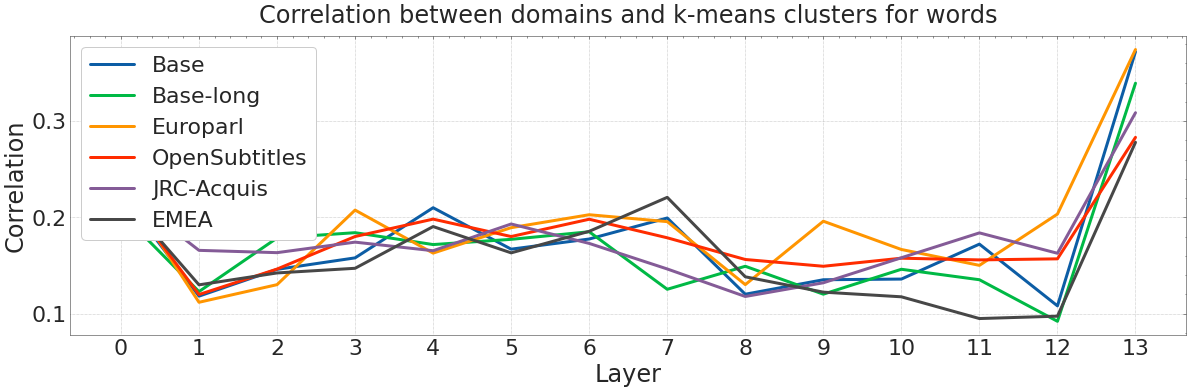

In [23]:
#fig, axs = plt.subplots(1, 4, figsize=(20,5.5))

fig, ax = plt.subplots(1, 1, figsize=(20,5.5))
for name, corrs in all_corr_ks.items():
    #ax = axs[i]
    ax = sns.lineplot(x=list(range(len(corrs))), y=corrs, ax=ax, label=name, linewidth=3)
    
    ax.set_xticks(list(range(len(corrs))))
    ax.set_title(f"Correlation between domains and k-means clusters for words", y=1.025)
    ax.set_ylabel("Correlation")
    ax.set_xlabel("Layer")
    #ax.set_ylim(0.25,1)
    ax.grid(True)
    #ax.legend(frameon=True, loc = 'upper left')#, bbox_to_anchor = (1.0, 0.5))
        
#fig.savefig("plots/abstraction_pattern_tuned_pawsx_multiling.pdf", bbox_inches='tight')

# plt.title("xlm-roberta-base representations similarity for language pairs")

# tsne

In [24]:
import warnings
warnings.filterwarnings('ignore')

In [25]:
num_examples = 300

hiddens_base = sample_words(hiddens_base, num_examples)
hiddens_base_2nd = sample_words(hiddens_base_2nd, num_examples)

hiddens_europarl = sample_words(hiddens_europarl, num_examples)
hiddens_opensubs = sample_words(hiddens_opensubs, num_examples)
hiddens_jrc = sample_words(hiddens_jrc, num_examples)
hiddens_emea = sample_words(hiddens_emea, num_examples)

In [26]:
def to_df(reps, labels):
    reps = pd.DataFrame(reps)
    reps['domain'] = labels
    return reps.sample(frac=1)

In [27]:
DOMAIN_NAMES = ["Europarl", "OpenSubtitles", "JRC-Acquis", "EMEA"]
NUM_LAYERS = 14

names = ['Base', 'Base-long'] + DOMAIN_NAMES
i = 0

all_reps_tsne = {}
all_labels = {}

for curr_all_hiddens in [hiddens_base, hiddens_base_2nd, hiddens_europarl, hiddens_opensubs, hiddens_jrc, hiddens_emea]:
    print(f'processing {names[i]}')
    
    reps_tsne = []
    labels_tsne = []
    hiddens_reps, hiddens_labels = prepare_reps(curr_all_hiddens)
    
    for l in range(NUM_LAYERS):

        indices = np.arange(hiddens_reps[l].shape[0])
        np.random.shuffle(indices)

        hiddens_shuff = hiddens_reps[l][indices][0:]
        labels_shuff = hiddens_labels[l][indices]

        hiddens_tsne = TSNE(
            n_components=2, 
            verbose=0, 
            n_jobs=-1, 
            metric='cosine', 
            perplexity=30, 
            init='random').fit_transform(hiddens_shuff)

        reps_tsne.append(hiddens_tsne)
        labels_tsne.append(labels_shuff)
        
    all_reps_tsne[names[i]] = reps_tsne
    all_labels[names[i]] = labels_tsne
    
    i += 1
    print()



processing Base

processing Base-long

processing Europarl

processing OpenSubtitles

processing JRC-Acquis

processing EMEA



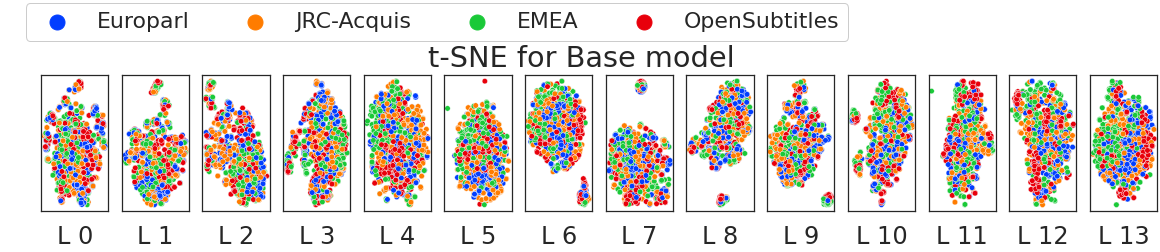

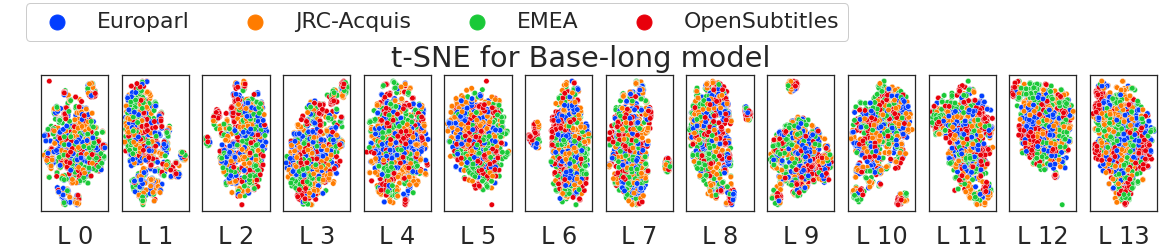

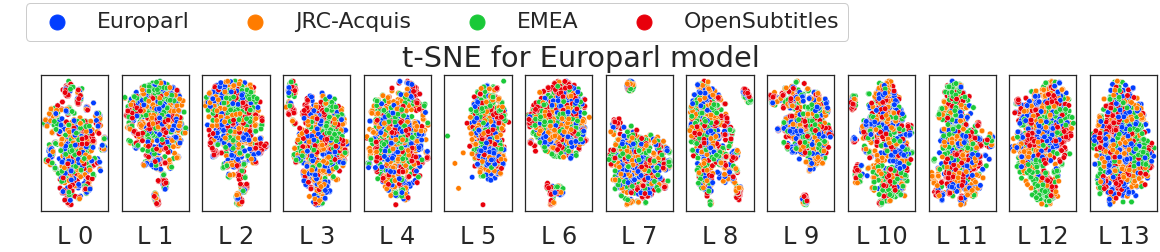

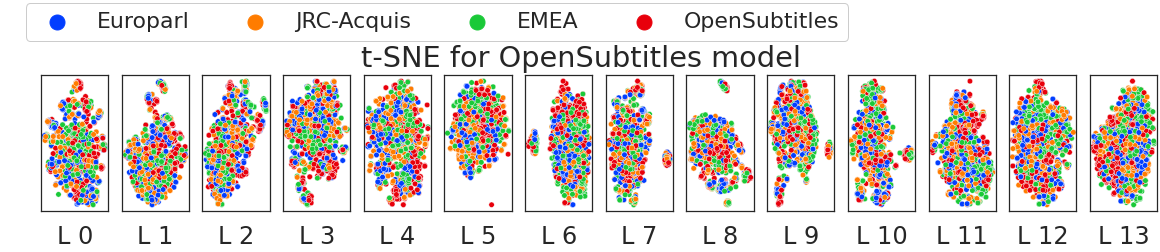

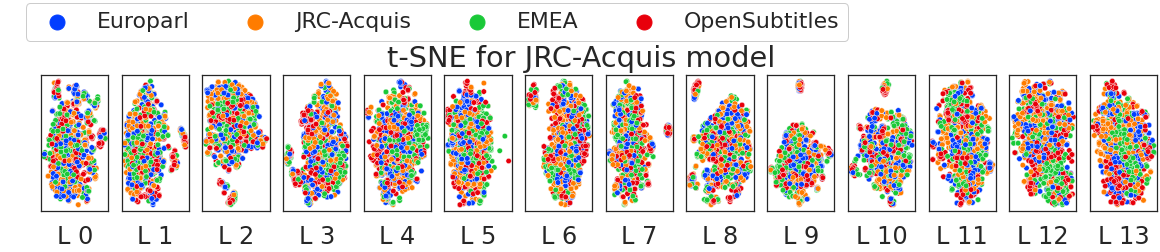

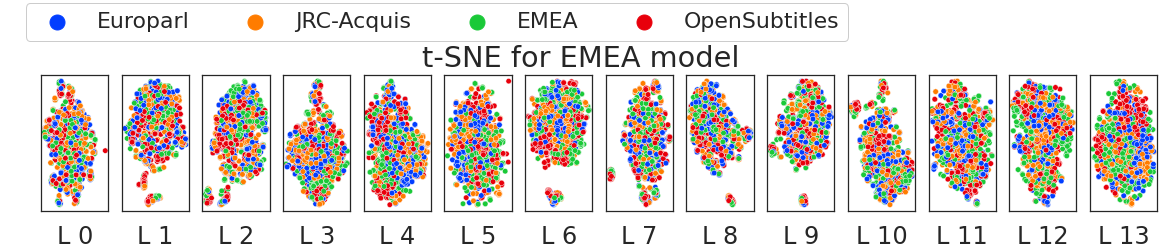

In [28]:
sns.set(font_scale=2)
sns.set_style("white")
sns.set_palette("bright")

for k, reps_tsne in all_reps_tsne.items():
    
    labels = all_labels[k]
    
    fig, axs = plt.subplots(1, NUM_LAYERS, figsize=(20,2.5))

    for num_layer in range(NUM_LAYERS):
        
        df = to_df(reps_tsne[num_layer], labels[num_layer]).sample(frac=1)
        
        sns.scatterplot(ax = axs[num_layer], x=df[0], y=df[1],
                        hue=df['domain'], hue_order=["Europarl", "JRC-Acquis", "EMEA", "OpenSubtitles"], 
                        s=30)

    #     sns.FacetGrid(ax=axs[ind], data=df, hue="domain", size=6) \
    #        .map(plt.scatter, 0, 1) \
    #        .add_legend()
        
        axs[num_layer].set_xticklabels(" ")
        axs[num_layer].set_yticklabels(" ")
        axs[num_layer].set_xlabel(f"L {num_layer}")
        axs[num_layer].set_ylabel(" ")    
        axs[num_layer].legend().set_visible(False)

        #if num_layer == 0:
        #    pass
            #axs[ind].legend().set_visible(True)
            #axs[ind].legend
            #ax.legend(frameon=True, loc = 'upper left')#, bbox_to_anchor = (1.0, 0.5))
    #axs[num_layer].set_title(f"T-SNE for {k} tuned model")
    handles, ax_labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, ax_labels, loc='upper center', ncol=6,  markerscale=2.5, bbox_to_anchor=(0.4,1.34))
    fig.suptitle(f"t-SNE for {k} model", y=1.05)
    #fig.savefig("plots/tsne_abstraction_pattern.pdf", bbox_inches='tight')

# PCA

In [29]:
num_examples = 300

hiddens_base = sample_words(hiddens_base, num_examples)
hiddens_base_2nd = sample_words(hiddens_base_2nd, num_examples)

hiddens_europarl = sample_words(hiddens_europarl, num_examples)
hiddens_opensubs = sample_words(hiddens_opensubs, num_examples)
hiddens_jrc = sample_words(hiddens_jrc, num_examples)
hiddens_emea = sample_words(hiddens_emea, num_examples)

In [30]:
def to_df(reps, labels):
    reps = pd.DataFrame(reps)
    reps['domain'] = labels
    return reps.sample(frac=1)

In [31]:
DOMAIN_NAMES = ["Europarl", "OpenSubtitles", "JRC-Acquis", "EMEA"]
NUM_LAYERS = 14

names = ['Base', 'Base-long'] + DOMAIN_NAMES
i = 0

all_reps_pca = {}
all_labels = {}

for curr_all_hiddens in [hiddens_base, hiddens_base_2nd, hiddens_europarl, hiddens_opensubs, hiddens_jrc, hiddens_emea]:
    print(f'processing {names[i]}')
    
    reps_pca = []
    labels_pca = []
    hiddens_reps, hiddens_labels = prepare_reps(curr_all_hiddens)
    
    for l in range(NUM_LAYERS):

        indices = np.arange(hiddens_reps[l].shape[0])
        np.random.shuffle(indices)

        hiddens_shuff = hiddens_reps[l][indices][0:]
        labels_shuff = hiddens_labels[l][indices]

        hiddens_pca = PCA(
            n_components=2, 
            random_state=0,
            ).fit_transform(hiddens_shuff)

        reps_pca.append(hiddens_pca)
        labels_pca.append(labels_shuff)
        
    all_reps_pca[names[i]] = reps_pca
    all_labels[names[i]] = labels_pca
    
    i += 1
    print()



processing Base

processing Base-long

processing Europarl

processing OpenSubtitles

processing JRC-Acquis

processing EMEA



## Words from different sentences (function sample_words(...) is used)

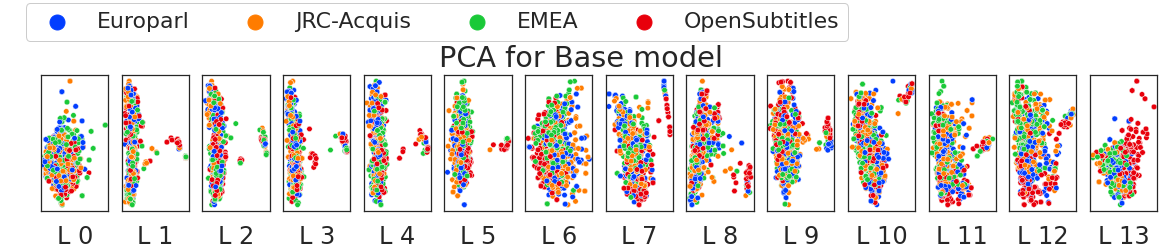

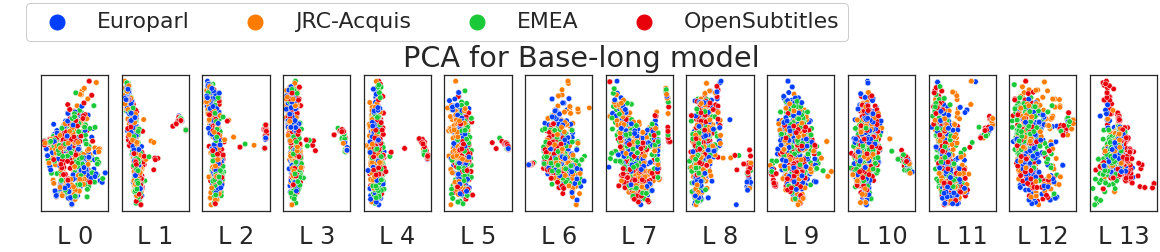

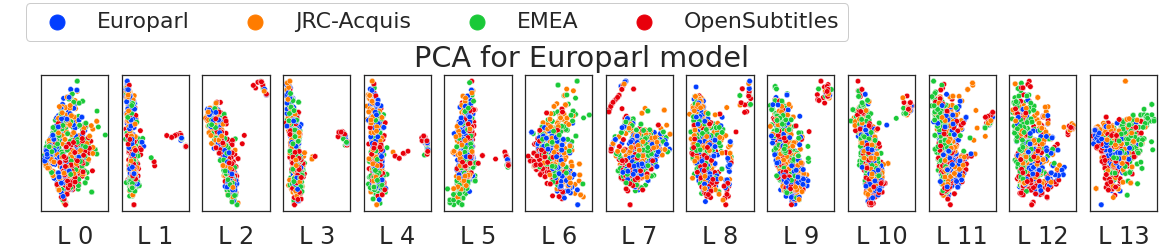

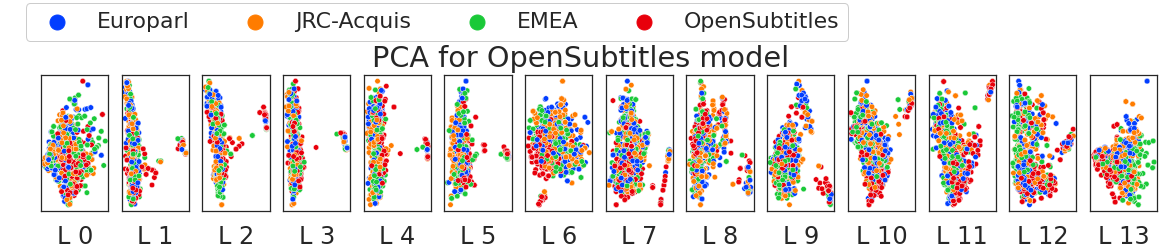

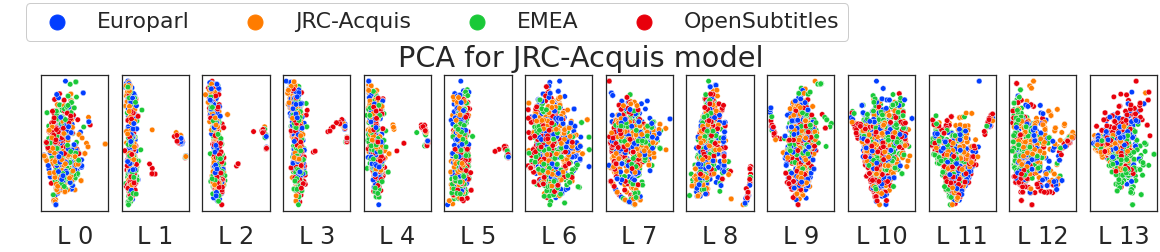

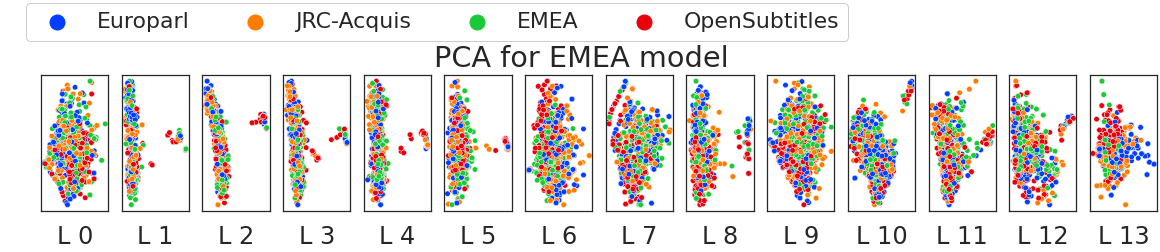

In [32]:
sns.set(font_scale=2)
sns.set_style("white")
sns.set_palette("bright")

for k, reps_pca in all_reps_pca.items():
    
    labels = all_labels[k]
    
    fig, axs = plt.subplots(1, NUM_LAYERS, figsize=(20,2.5))

    for num_layer in range(NUM_LAYERS):
        
        df = to_df(reps_pca[num_layer], labels[num_layer]).sample(frac=1)
        
        sns.scatterplot(ax = axs[num_layer], x=df[0], y=df[1],
                        hue=df['domain'], hue_order=["Europarl", "JRC-Acquis", "EMEA", "OpenSubtitles"], 
                        s=30)

    #     sns.FacetGrid(ax=axs[ind], data=df, hue="domain", size=6) \
    #        .map(plt.scatter, 0, 1) \
    #        .add_legend()
        
        axs[num_layer].set_xticklabels(" ")
        axs[num_layer].set_yticklabels(" ")
        axs[num_layer].set_xlabel(f"L {num_layer}")
        axs[num_layer].set_ylabel(" ")    
        axs[num_layer].legend().set_visible(False)

        #if num_layer == 0:
        #    pass
            #axs[ind].legend().set_visible(True)
            #axs[ind].legend
            #ax.legend(frameon=True, loc = 'upper left')#, bbox_to_anchor = (1.0, 0.5))
    #axs[num_layer].set_title(f"T-SNE for {k} tuned model")
    handles, ax_labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, ax_labels, loc='upper center', ncol=6,  markerscale=2.5, bbox_to_anchor=(0.4,1.34))
    fig.suptitle(f"PCA for {k} model", y=1.05)
    #fig.savefig("plots/tsne_abstraction_pattern.pdf", bbox_inches='tight')